In [1]:
import __init__
from src.utilities import train_test_validation_splits, \
                            prepare_train_test_val_seqs_by_batches, \
                            tensor2dataloader, load_full_meltome_FLIP_db, \
                            seek_UniprotID_association_Meltome_prots,\
                            download_UniprotID_Alphafold_Structures,\
                            handle_nans,\
                            load_fasta_to_df
                            
import pandas as pd
import numpy as np
    
path_meltome = '../datasets/FLIP/splits/meltome/splits/mixed_split.csv'
complete_meltome_db = '../datasets/FLIP/splits/meltome/full_dataset_sequences.fasta'
Gustav_preprocesed_meltome_db = '../datasets/dataset_Gustav_repro/meltome_preprocessed.tsv'

full_meltome_db = load_full_meltome_FLIP_db(complete_meltome_db)

#splits_meltome = pd.read_csv(path_meltome, sep=',')
#filtered_set_gustav = pd.read_csv(Gustav_preprocesed_meltome_db, sep='\t')

# Absolute
target_cols = ['tm']
num_targets = len(target_cols)

# Load data
df = pd.read_csv('../datasets/dataset_Gustav_repro/meltome_preprocessed.tsv', sep='\t', index_col = 'key')

# Remove nan from df
df = handle_nans(df, target_columns = ['tm', 'sequence'], method='remove')

# delete duplicate cols
df = df.drop('sequence', 1)

# Load train, test, valid fasta
df_train = load_fasta_to_df('../datasets/dataset_Gustav_repro/meltome_train.faa')
df_valid = load_fasta_to_df('../datasets/dataset_Gustav_repro/meltome_valid.faa')
df_test = load_fasta_to_df('../datasets/dataset_Gustav_repro/meltome_test.faa')

# Merge
train = df_train.join(df, how = 'left').reset_index().rename(columns = {'tm':'target'})
val = df_valid.join(df, how = 'left').reset_index().rename(columns = {'tm':'target'})
test = df_test.join(df, how = 'left').reset_index().rename(columns = {'tm':'target'})






#ff=full_meltome_db[full_meltome_db['sequence'].isin(train['sequence'])]

0 observations were removed which had one or more unknown Tm
Final number of proteins: 25232


/tmp/ipykernel_435270/29308749.py:33: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  df = df.drop('sequence', 1)


In [2]:
from tqdm.auto import tqdm
import torch, os
from src.ESM2embeddings import ESM2embeddings
from src.utilities import train_test_validation_splits, prepare_train_test_val_seqs_by_batches, tensor2dataloader
from src.NeuralArchitectures import regressionHead
from src.Trainer import Trainer

structuredir = '../datasets/Structures/'
meltome_struct_dir_labels = '../datasets/'

In [3]:

import torch
import torch_geometric
import torch_sparse
from torch_geometric.nn import MessagePassing

import esm


pt_batch_size = 16
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

ESM2 = ESM2embeddings(type_embedding = "facebook/esm2_t33_650M_UR50D", device = device, type_tool='FacebookESM2')

dir_pre_generated_embeddings = '../prepro_embeddings/'

path_train= dir_pre_generated_embeddings+'train_set_embeddings_ESM2_Gustav_data.pth'
path_test= dir_pre_generated_embeddings+'test_set_embeddings_ESM2_Gustav_data.pth'
path_val= dir_pre_generated_embeddings+'val_set_embeddings_ESM2_Gustav_data.pth'



def embedding_builder_ESM2(ESM2, device, train, test, val, path_train, path_test, path_val):
    if os.path.isfile(path_train)==False and os.path.isfile(path_test)==False and os.path.isfile(path_val)==False:

        """batch_train, batch_test, batch_val = prepare_train_test_val_seqs_by_batches(train.sequence.to_list(), 
                                                                                    test.sequence.to_list(), 
                                                                                    val.sequence.to_list(), 
                                                                                    batch_size=2)"""
        print ("Creating Embeddings...")   
        train_embeddings = ESM2.esm2embedding(train, device, layer_index=33) #esm2embedding(train, model, batch_converter, device, layer_index=33)#BERT.embed_dataset(batch_train)
        torch.save(train_embeddings, path_train)
        test_embeddings = ESM2.esm2embedding(test, device, layer_index=33) #esm2embedding(test, model, batch_converter, device, layer_index=33)
        torch.save(test_embeddings, path_test)
        val_embeddings = ESM2.esm2embedding(val, device, layer_index=33) #esm2embedding(val, model, batch_converter, device, layer_index=33)
        torch.save(val_embeddings, path_val)
        print ("Loaded")
    else:
        print ("Loading Premade Embeddings...")
        train_embeddings = torch.load(path_train)
        test_embeddings = torch.load(path_test)
        val_embeddings = torch.load(path_val)
        print ("Loaded")
    return train_embeddings, test_embeddings, val_embeddings






In [4]:
train_embeddings, test_embeddings, val_embeddings = embedding_builder_ESM2(ESM2, device, train, test, val,  path_train, path_test, path_val)

train_loader = tensor2dataloader(train_embeddings, torch.from_numpy( train.target.to_numpy() ), batch_size=50)
test_loader = tensor2dataloader(test_embeddings, torch.from_numpy( test.target.to_numpy() ), batch_size=50)
val_loader = tensor2dataloader(val_embeddings, torch.from_numpy( val.target.to_numpy() ), batch_size=50)

Loading Premade Embeddings...
Loaded


In [5]:
Trainer = Trainer()
model = regressionHead(train_embeddings.shape[1::])
opt = torch.optim.Adam(model.parameters(), lr=1e-4)
loss= torch.nn.MSELoss()
epochs = 200
model, val_loss = Trainer.train_LLMRegresor(train_loader, val_loader, model, device, loss, opt, epochs)

epoch: 1 loss: 1466.602 val loss: 1422.959
epoch: 2 loss: 675.576 val loss: 809.147
epoch: 3 loss: 541.521 val loss: 453.350
epoch: 4 loss: 346.421 val loss: 264.446
epoch: 5 loss: 289.097 val loss: 178.111
epoch: 6 loss: 107.642 val loss: 146.166
epoch: 7 loss: 91.661 val loss: 135.371
epoch: 8 loss: 122.851 val loss: 135.875
epoch: 9 loss: 90.650 val loss: 133.382
epoch: 10 loss: 94.890 val loss: 133.208
epoch: 11 loss: 72.750 val loss: 133.842
epoch: 12 loss: 136.347 val loss: 134.390
epoch: 13 loss: 82.892 val loss: 134.350
epoch: 14 loss: 109.210 val loss: 132.693
epoch: 15 loss: 170.266 val loss: 111.409
epoch: 16 loss: 53.083 val loss: 86.464
epoch: 17 loss: 57.383 val loss: 70.444
epoch: 18 loss: 64.452 val loss: 59.920
epoch: 19 loss: 37.619 val loss: 53.159
epoch: 20 loss: 73.025 val loss: 50.993
epoch: 21 loss: 36.265 val loss: 47.634
epoch: 22 loss: 56.306 val loss: 46.804
epoch: 23 loss: 39.632 val loss: 45.405
epoch: 24 loss: 49.910 val loss: 44.256
epoch: 25 loss: 65.220

MSE: tensor(40.0894, device='cuda:0', grad_fn=<MseLossBackward0>)
RMSE: tensor(6.3316, device='cuda:0', grad_fn=<SqrtBackward0>)
MAE: tensor(4.6747, device='cuda:0', grad_fn=<MeanBackward0>)


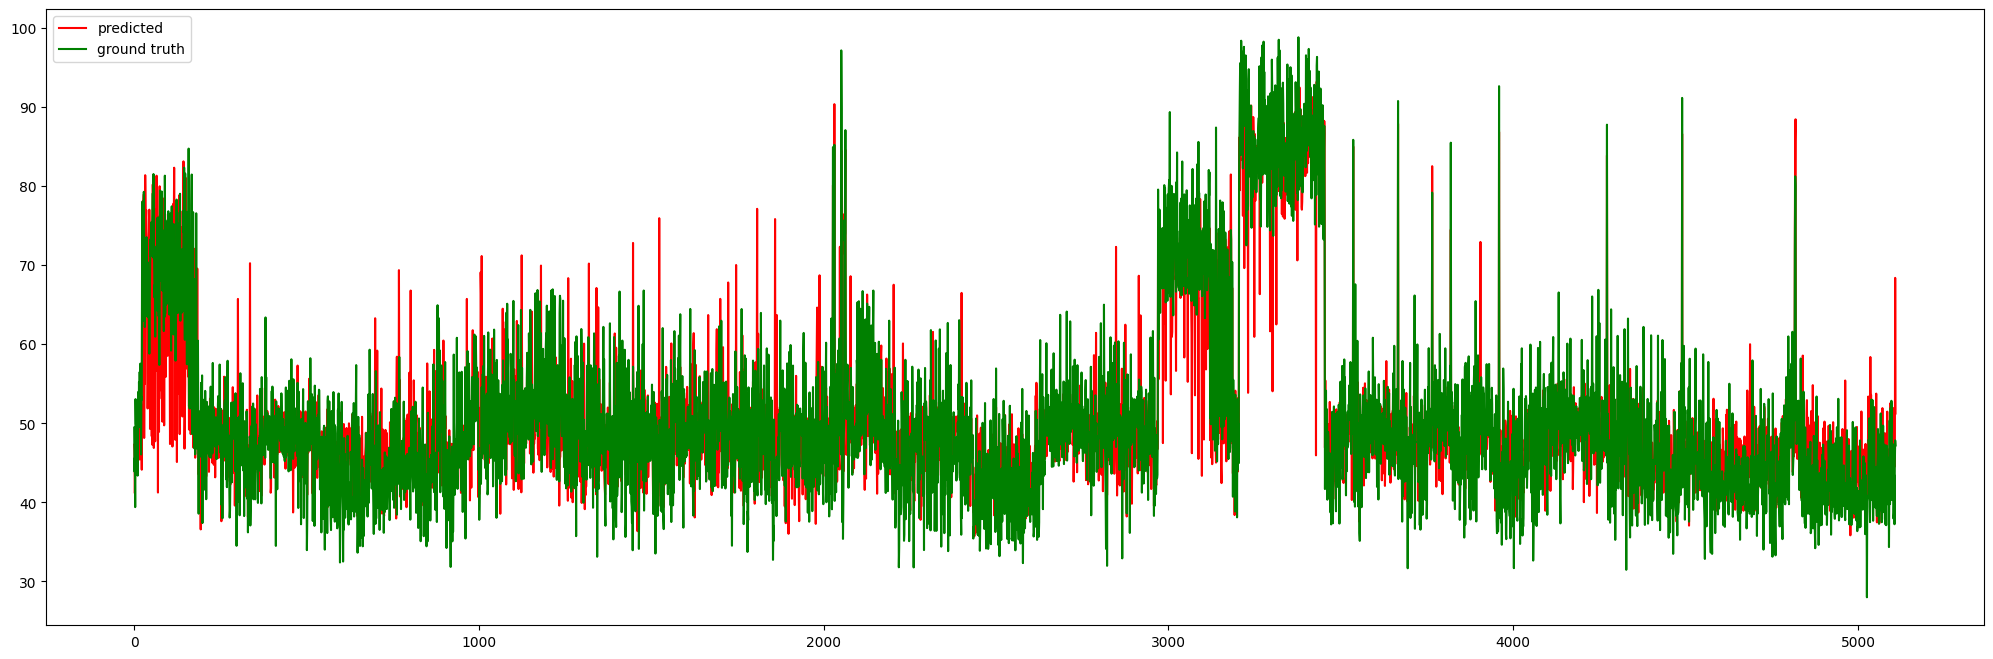

In [6]:
test_set, test_labels = test_loader.dataset.tensors
loss_test, outcome = Trainer.test_model(model, test_set, test_labels, loss, device)


from src.utilities import plot_results

plot_results( outcome, test_labels) 